In [1]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt

print("python:", sys.executable)

def find_root():
    p = Path.cwd().resolve()
    for _ in range(12):
        if (p / "data").exists():
            return p
        p = p.parent
    raise FileNotFoundError("No encuentro /data. Abre el notebook dentro del repo.")

ROOT = find_root()
ROOT


python: c:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\.venv\Scripts\python.exe


WindowsPath('C:/Users/patxi/Documents/GitHub/bicing-barcelona-ml')

In [2]:
import pyarrow.parquet as pq

SAMPLE = ROOT / "data" / "gold" / "samples" / "bicing_gold_final_plus_sample_1M_strat_holidays.parquet"
assert SAMPLE.exists(), f"No existe: {SAMPLE}. Ejecuta antes 01_make_sample_stratified_holidays.py"

df = pq.read_table(SAMPLE).to_pandas()

df["time_hour"] = pd.to_datetime(df["time_hour"])
df["date"] = pd.to_datetime(df["date"]).dt.date  # nos vale por día

print("shape:", df.shape)
print("time:", df["time_hour"].min(), "->", df["time_hour"].max())
df.head(3)


shape: (682303, 27)
time: 2019-03-28 18:00:00 -> 2025-12-31 23:00:00


,station_id,time_hour,bikes_available_mean,docks_available_mean,mechanical_mean,ebike_mean,obs_count,hour,dayofweek,month,...,pressure_msl,lag_1h_bikes,lag_24h_bikes,roll3h_bikes_mean,is_holiday_new,is_holiday_barcelona,is_holiday_catalunya,is_holiday_spain,holiday_scope,holiday_name
0,505,2025-12-28 12:00:00,0.750000,25.166667,0.000000,0.750000,12,12,6,12,...,1020.5,4.250000,2.000000,4.527778,0,0,0,0,NaN,NaN
1,326,2022-09-20 18:00:00,0.545455,30.272727,0.000000,0.545455,11,18,1,9,...,1017.2,0.916667,0.416667,0.737374,0,0,0,0,NaN,NaN
2,143,2019-06-22 14:00:00,25.833333,1.166667,21.083333,4.750000,12,14,5,6,...,1014.6,26.500000,22.583333,25.527778,0,0,0,0,NaN,NaN


In [3]:
holiday_cols = [c for c in df.columns if "holiday" in c.lower() or "festiv" in c.lower()]
print("holiday columns:", holiday_cols)

required = [
    "station_id", "time_hour", "date", "bikes_available_mean",
    "is_holiday_barcelona", "is_holiday_catalunya", "is_holiday_spain",
    "holiday_scope", "holiday_name",
]
missing = [c for c in required if c not in df.columns]
print("missing:", missing)

dup_keys = df.duplicated(["station_id", "time_hour"]).sum()
print("dup_keys(sample) =", dup_keys)

# Holiday-any calculado (para no depender de is_holiday / is_holiday_new)
df["is_holiday_any"] = (
    (df["is_holiday_barcelona"].fillna(0).astype(int) == 1) |
    (df["is_holiday_catalunya"].fillna(0).astype(int) == 1) |
    (df["is_holiday_spain"].fillna(0).astype(int) == 1)
).astype(int)

df["is_holiday_any"].value_counts(dropna=False)


holiday columns: ['is_holiday', 'is_holiday_new', 'is_holiday_barcelona', 'is_holiday_catalunya', 'is_holiday_spain', 'holiday_scope', 'holiday_name']
missing: []
dup_keys(sample) = 0


is_holiday_any
0    669021
1     13282
Name: count, dtype: int64

In [4]:
counts = pd.Series({
    "holiday_any": int(df["is_holiday_any"].sum()),
    "holiday_bcn": int(df["is_holiday_barcelona"].fillna(0).sum()),
    "holiday_cat": int(df["is_holiday_catalunya"].fillna(0).sum()),
    "holiday_es": int(df["is_holiday_spain"].fillna(0).sum()),
})
counts


holiday_any    13282
holiday_bcn     1815
holiday_cat     4083
holiday_es      7384
dtype: int64

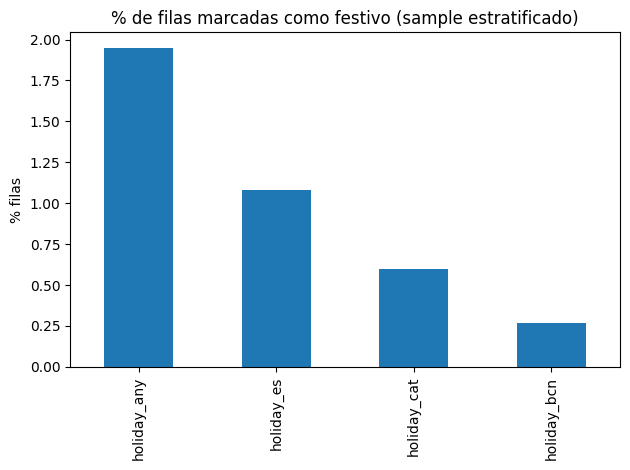

In [5]:
plt.figure()
(counts / len(df) * 100).sort_values(ascending=False).plot(kind="bar")
plt.title("% de filas marcadas como festivo (sample estratificado)")
plt.ylabel("% filas")
plt.tight_layout()
plt.show()


C:\Users\patxi\AppData\Local\Temp\ipykernel_14528\1847551341.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0, d1], labels=["No festivo", "Festivo (any)"])


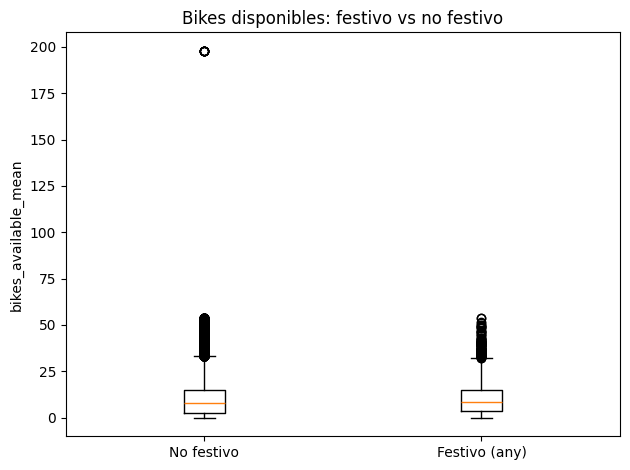

mean non-holiday: 9.706255614883192
mean holiday: 10.017738778877225


In [6]:
d0 = df.loc[df["is_holiday_any"] == 0, "bikes_available_mean"].dropna()
d1 = df.loc[df["is_holiday_any"] == 1, "bikes_available_mean"].dropna()

plt.figure()
plt.boxplot([d0, d1], labels=["No festivo", "Festivo (any)"])
plt.title("Bikes disponibles: festivo vs no festivo")
plt.ylabel("bikes_available_mean")
plt.tight_layout()
plt.show()

print("mean non-holiday:", d0.mean())
print("mean holiday:", d1.mean())


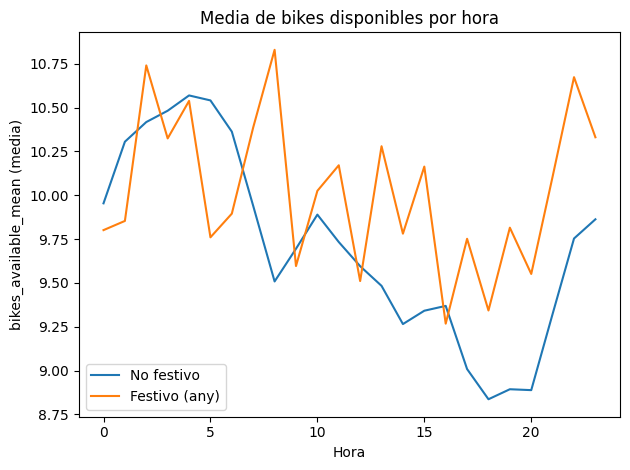

In [7]:
df["hour"] = df["time_hour"].dt.hour

g = df.groupby(["hour", "is_holiday_any"], as_index=False)["bikes_available_mean"].mean()
g0 = g[g["is_holiday_any"] == 0].set_index("hour")["bikes_available_mean"]
g1 = g[g["is_holiday_any"] == 1].set_index("hour")["bikes_available_mean"]

plt.figure()
plt.plot(g0.index, g0.values, label="No festivo")
plt.plot(g1.index, g1.values, label="Festivo (any)")
plt.title("Media de bikes disponibles por hora")
plt.xlabel("Hora")
plt.ylabel("bikes_available_mean (media)")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
wide = g.pivot(index="hour", columns="is_holiday_any", values="bikes_available_mean").rename(columns={0:"non_h", 1:"hol"})
wide["delta_hol_minus_non"] = wide["hol"] - wide["non_h"]
wide


is_holiday_any,non_h,hol,delta_hol_minus_non
hour,,,
0,9.953932,9.801078,-0.152855
1,10.305592,9.853467,-0.452125
2,10.417747,10.740969,0.323222
3,10.482316,10.324437,-0.157879
4,10.569632,10.538365,-0.031267
5,10.541198,9.759937,-0.781261
6,10.362905,9.895095,-0.467810
7,9.939001,10.387330,0.448330
8,9.508165,10.829995,1.321829


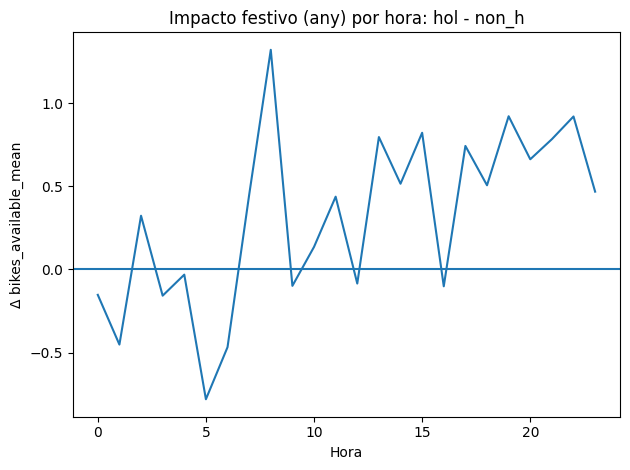

Δ medio (promedio de horas): 0.31170754871727896


In [9]:
plt.figure()
plt.plot(wide.index, wide["delta_hol_minus_non"].values)
plt.axhline(0)
plt.title("Impacto festivo (any) por hora: hol - non_h")
plt.xlabel("Hora")
plt.ylabel("Δ bikes_available_mean")
plt.tight_layout()
plt.show()

print("Δ medio (promedio de horas):", wide["delta_hol_minus_non"].mean())


In [10]:
hol_days = (
    df[df["is_holiday_any"] == 1]
    .groupby(["date", "holiday_scope", "holiday_name"], as_index=False)
    .agg(n_rows=("station_id", "size"), mean_bikes=("bikes_available_mean", "mean"))
    .sort_values(["date", "holiday_scope"])
)

hol_days.head(20)


,date,holiday_scope,holiday_name,n_rows,mean_bikes
0,2019-04-19,catalunya,Viernes Santo,110,13.962218
1,2019-04-22,catalunya,Lunes de Pascua,118,14.697612
2,2019-05-01,spain,Fiesta del Trabajo,107,14.164951
3,2019-06-10,barcelona,Lunes de Pascua Granada (Segona Pasqua),114,12.655088
4,2019-06-24,catalunya,Sant Joan,105,11.636505
5,2019-08-15,spain,Asunción,92,12.702322
6,2019-09-11,catalunya,Diada Nacional de Catalunya,109,11.783987
7,2019-09-24,barcelona,La Mercè,123,9.862949
8,2019-10-12,spain,Fiesta Nacional de España,109,9.230497
9,2019-11-01,spain,Todos los Santos,105,10.873488


In [11]:
def label_scope(row):
    if int(row.get("is_holiday_barcelona", 0) or 0) == 1:
        return "barcelona"
    if int(row.get("is_holiday_catalunya", 0) or 0) == 1:
        return "catalunya"
    if int(row.get("is_holiday_spain", 0) or 0) == 1:
        return "spain"
    return "none"

df["holiday_level"] = df.apply(label_scope, axis=1)

scope_means = df.groupby("holiday_level")["bikes_available_mean"].mean().sort_values(ascending=False)
scope_means


holiday_level
spain        10.110307
catalunya     9.980854
barcelona     9.724117
none          9.706256
Name: bikes_available_mean, dtype: float64

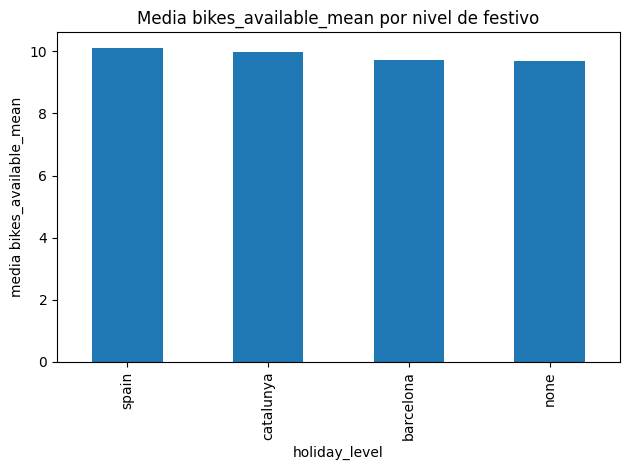

In [12]:
plt.figure()
scope_means.plot(kind="bar")
plt.title("Media bikes_available_mean por nivel de festivo")
plt.ylabel("media bikes_available_mean")
plt.tight_layout()
plt.show()


In [13]:
out_tables = ROOT / "reports" / "tables"
out_figs = ROOT / "reports" / "figures"
out_tables.mkdir(parents=True, exist_ok=True)
out_figs.mkdir(parents=True, exist_ok=True)

# Tablas
wide.to_csv(out_tables / "eda_holiday_impact_by_hour.csv", index=True)
hol_days.to_csv(out_tables / "eda_holiday_days_sample.csv", index=False)

print("✅ tablas:", out_tables)


✅ tablas: C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\reports\tables
